# Recovering rotation periods in simulated LSST data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gatspy.periodic import LombScargle
import sys
%matplotlib inline
from toy_simulator import simulate_LSST
from trilegal_models import random_stars
import simple_gyro as sg

Randomly select targets from a TRILEGAL output.

In [2]:
fname = "output574523944248.dat"
N = 100
logAges, bvs = random_stars(fname, N)

Calculate periods from ages and colours for cool stars

In [3]:
m = bvs > .4  # select only cool stars
cool_ages = 10**logAges[m] * 1e-9
cool_ps = sg.period(cool_ages, bvs[m])

Draw from a sum of two Gaussians (modelled in another notebook) that describes the period distribution for hot stars. Approximations: I have lumped all stars with colour < 0.4 in together AND I actually used teff = 6250, not B-V = 0.4 in the other notebook.

In [12]:
hot_ages = 10**logAges[~m] * 1e-9 # select hot stars
# copy parameters from hot_stars ipython notebook
A1, A2, mu1, mu2, sig1, sig2 = 254.11651209, 49.8149765, 3.00751724, 3.73399554, 2.26525979, 8.31739725

hot_ps = np.zeros_like(hot_ages)
hot_ps1 = np.random.randn(int(len(hot_ages)*(1 - A2/A1)))*sig1 + mu1  # mode 1
hot_ps2 = np.random.randn(int(len(hot_ages)*(A2/A1)))*sig2 + mu2  # mode 2
hot_ps[:len(hot_ps1)] = hot_ps1
hot_ps[len(hot_ps1):len(hot_ps2)] = hot_ps2
tot = len(hot_ps1) + len(hot_ps2)
hot_ps[tot:] = np.random.randn(len(hot_ps)-tot)*sig2 + mu2
age = np.concatenate((cool_ages, hot_ages))
ps = np.concatenate((cool_ps, hot_ps))

Make histograms of the ages and periods

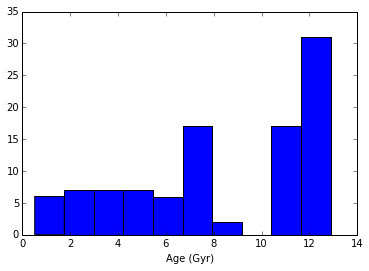

In [13]:
plt.hist(age)
plt.xlabel("Age (Gyr)")

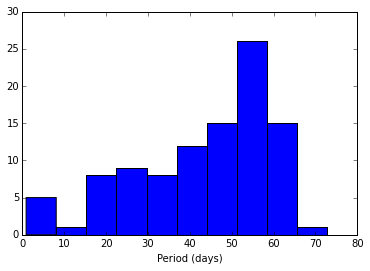

In [14]:
plt.hist(ps)
plt.xlabel("Period (days)")

In [15]:
## Arrays of random (log-normal) periods and (uniform) amplitudes.
#min_period, max_period = 1, 100  # days
#ps = np.exp(np.random.uniform(np.log(min_period), np.log(max_period), N))  # periods
#amps = np.random.uniform(10, 300, N)  # ppm

Simulate light curves

In [16]:
%%capture
amps = np.random.uniform(10, 300, N)  # ppm
path = "simulations"  # where to save the lcs
[simulate_LSST(i, ps[i], amps[i], path) for i in range(N)]  # simulations

# save the true values
ids = np.arange(N)
data = np.vstack((ids, ps, amps))
np.savetxt("{0}/truth.txt".format(path), data.T)

Load and plot an example light curve

<Container object of 3 artists>

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


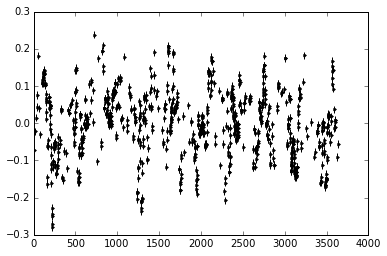

In [17]:
id = 0
sid = str(int(id)).zfill(4)
path = "results"  # where to save results
x, y, yerr = np.genfromtxt("simulations/{0}.txt".format(sid)).T  # load a fake light curve
plt.errorbar(x, y, yerr=yerr, fmt="k.", capsize=0)

Compute a periodogram

59.4854854855 57.3654078601


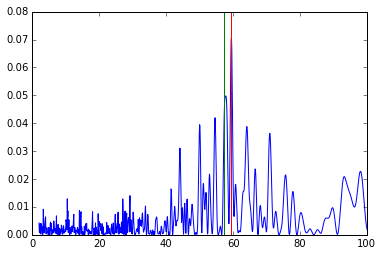

In [18]:
ps = np.linspace(2, 100, 1000)  # the period array (in days)
model = LombScargle().fit(x, y, yerr)
pgram = model.periodogram(ps)

# find peaks
peaks = np.array([i for i in range(1, len(ps)-1) if pgram[i-1] < pgram[i] and pgram[i+1] < pgram[i]])
if len(peaks):
    period = ps[pgram==max(pgram[peaks])][0]
else: period = 0

plt.plot(ps, pgram)  # plot the pgram
plt.axvline(period, color="r")  # plot the position of the highest peak

# load and plot the truth
ids, true_ps, true_as = np.genfromtxt("simulations/truth.txt").T
plt.axvline(true_ps[id], color="g")  # plot the position of the highest peak

print(period, true_ps[id])

Now compute LS pgrams for a set of LSST light curves and save the highest peak .

In [19]:
ids = np.arange(N)
periods = np.zeros_like(ids)
for i, id in enumerate(ids):
    sid = str(int(id)).zfill(4)
    x, y, yerr = np.genfromtxt("simulations/{0}.txt".format(sid)).T  # load a fake light curve

    model = LombScargle().fit(x, y, yerr)  # compute pgram
    pgram = model.periodogram(ps)

    # find peaks
    peaks = np.array([i for i in range(1, len(ps)-1) if pgram[i-1] < pgram[i] and pgram[i+1] < pgram[i]])
    if len(peaks):
        period = ps[pgram==max(pgram[peaks])][0]
    else: period = 0

    periods[i] = period

Plot the recovered periods vs the true periods.

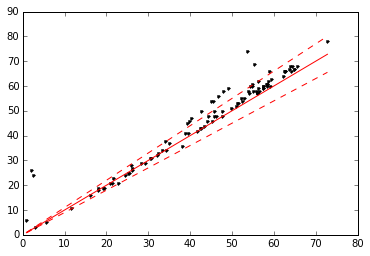

In [20]:
plt.plot(true_ps, periods, "k.")
xs = np.linspace(min(true_ps), max(true_ps), 100)
plt.plot(xs, xs, "r")

tau = .1  # the recovery must be within a factor of *threshold* of the truth
plt.plot(xs, xs-tau*xs, "r--")
plt.plot(xs, xs+tau*xs, "r--")

Decide whether the recovery was successful or not

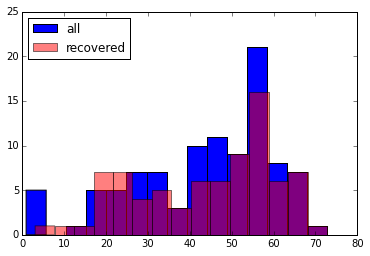

In [24]:
m = (true_ps - tau*true_ps < periods) * (periods < true_ps + tau*true_ps)

plt.hist(true_ps, 15, color="b", label="all")
plt.hist(true_ps[m], 15, color="r", alpha=.5, label="recovered")
plt.legend(loc="best")

Still need: 
1. Build in amplitude as a function of rotation period/teff